In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow import keras

import pandas as pd
import vaex
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['font.size'] = 16

sns.set_theme()

In [3]:
def lag(y, num_inputs):
    """ Transforma a saída 'y' em uma entrada + saída atrasada
    
    Args:
        y (array): valores de saída da função alvo
        
    Returns:
        x_mod (array): novos valores de entrada (retirados do y)
        y_mod (array): novos valores de saída
    """
    x_mod, y_mod = [], []
    
    for ind in range(len(y)-num_inputs):
        x_mod.append(y[ind:ind+num_inputs])
        y_mod.append(y[ind+num_inputs])
    
    x_mod = np.array(x_mod).reshape(-1, num_inputs)
    y_mod = np.array(y_mod).reshape(-1, 1)
    
    return x_mod, y_mod

# 01. Pré-processamento

In [4]:
# Carregando os dados
dados = pd.read_csv('Passageiros.csv')
display(dados.head())

x = dados.tempo
y = dados.passageiros

,tempo,passageiros
0,1949.000000,112
1,1949.083333,118
2,1949.166667,132
3,1949.250000,129
4,1949.333333,121


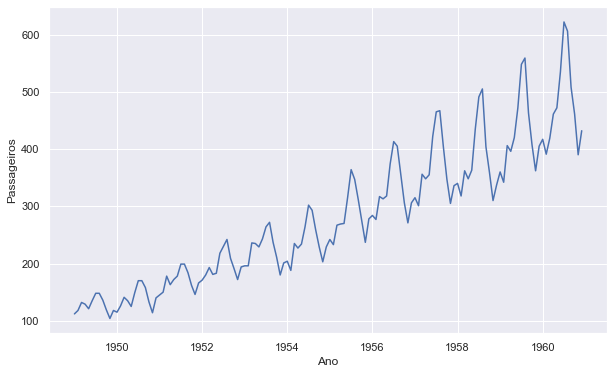

In [5]:
# Visualizando o dataset completo
plt.figure()
sns.lineplot(x=dados.tempo, y=dados.passageiros)
plt.xlabel('Ano')
plt.ylabel('Passageiros')
plt.show()

Como o objetivo é realizar uma previsão, a divisão do dataset entre treino e teste será feita *sem* embaralhamento, de forma que a parte final fica reservada para testes.

A normalização dos dados é feita ajustando o normalizador com os dados de teste e, em seguida, transformando os de teste e treino. No curso, os dados foram separados *após* a normalização o que não é uma prática recomendada, pois causa vazamento de informações do subset de testes no de treino (a normalização é feita considerando informações que os dados de treino supostamente deveria não conhecer).

In [6]:
# Divisão treino/teste
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.2, shuffle=False)

# Instanciar os normalizadores
normalizador_x = StandardScaler().fit(x_treino.values.reshape(-1, 1))
normalizador_y = StandardScaler().fit(y_treino.values.reshape(-1, 1))
# Transformar os dados
x_treino_norm = normalizador_x.transform(x_treino.values.reshape(-1, 1))
x_teste_norm = normalizador_x.transform(x_teste.values.reshape(-1, 1))
y_treino_norm = normalizador_y.transform(y_treino.values.reshape(-1, 1))
y_teste_norm = normalizador_y.transform(y_teste.values.reshape(-1, 1))

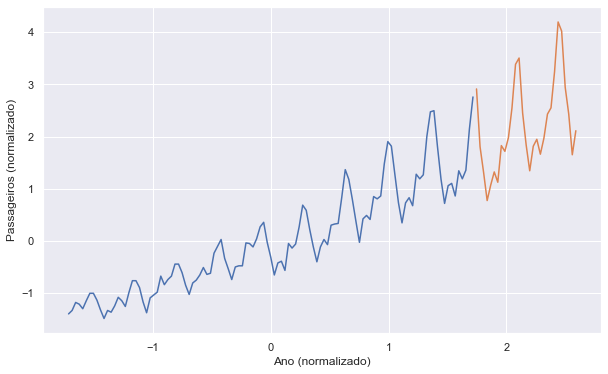

In [7]:
# Visualizar o dataset segregado
plt.figure()
sns.lineplot(x=x_treino_norm[:,0], y=y_treino_norm[:,0])
sns.lineplot(x=x_teste_norm[:,0], y=y_teste_norm[:,0])
plt.xlabel('Ano (normalizado)')
plt.ylabel('Passageiros (normalizado)')
plt.show()

# 02. Regressão

In [8]:
# Definição do modelo de 1 parâmetro, linear:
regressor = keras.Sequential([
    keras.layers.Dense(1, input_dim=1, activation='linear', kernel_initializer='ones')
])

# Compilando
regressor.compile(loss='mean_squared_error', optimizer='adam')

# Ajustando
regressor.fit(x_treino_norm, y_treino_norm)

4/4 [==============================] - 0s 3ms/step - loss: 0.1650


1/1 [==============================] - 0s 16ms/step


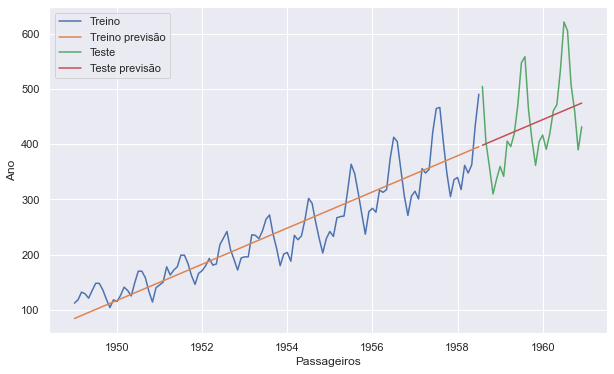

In [9]:
# Previsões (nos valores reais)
y_treino_predict = normalizador_y.inverse_transform(regressor.predict(x_treino_norm))
y_teste_predict = normalizador_y.inverse_transform(regressor.predict(x_teste_norm))

# Plots
plt.figure()
sns.lineplot(x=x_treino, y=y_treino, label='Treino')
sns.lineplot(x=x_treino, y=y_treino_predict.reshape(-1, 1)[:, 0], label='Treino previsão')
sns.lineplot(x=x_teste, y=y_teste, label='Teste')
sns.lineplot(x=x_teste, y=y_teste_predict.reshape(-1, 1)[:,0], label='Teste previsão')
plt.xlabel('Passageiros')
plt.ylabel('Ano')
plt.show()

1/1 [==============================] - 0s 24ms/step


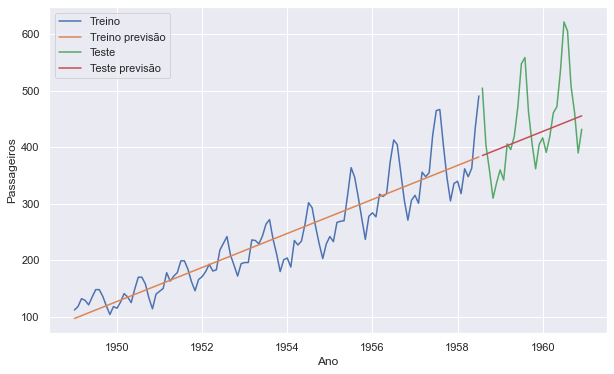

In [10]:
# Testando um modelo com mais camadas:
regressor_2 = keras.Sequential(
    [
        keras.layers.Dense(8, input_dim=1, kernel_initializer='random_uniform', activation='linear'),
        keras.layers.Dense(8, kernel_initializer='random_uniform', activation='linear'),
        keras.layers.Dense(1, kernel_initializer='random_uniform', activation='linear')
    ]
)

# Compilando e treinando
regressor_2.compile(loss='mean_squared_error', optimizer='adam')
regressor_2.fit(x_treino_norm, y_treino_norm, epochs=250, verbose=0)

# Previsões (nos valores reais)
y_treino_predict = normalizador_y.inverse_transform(regressor_2.predict(x_treino_norm))
y_teste_predict = normalizador_y.inverse_transform(regressor_2.predict(x_teste_norm))

# Plots
plt.figure()
sns.lineplot(x=x_treino, y=y_treino, label='Treino')
sns.lineplot(x=x_treino, y=y_treino_predict.reshape(-1, 1)[:, 0], label='Treino previsão')
sns.lineplot(x=x_teste, y=y_teste, label='Teste')
sns.lineplot(x=x_teste, y=y_teste_predict.reshape(-1, 1)[:,0], label='Teste previsão')
plt.xlabel('Ano')
plt.ylabel('Passageiros')
plt.show()

# 03. Alterando os dados

Nesses casos, a rede aprende a prever o número de passageiros por meio construindo uma função que usa o ano. Outra maneira de interpretar o problema é fazer com que o aprendizado receba o número de passageiros num dado período e tenha como saída em outro, ou seja, ambos input e output serão em quantidade de passageiros, porém com X atrasado no tempo.

Assim, definiu-se a função 'lag' e, nela, é possível definir um número de inputs para x usado para definir cada valor de y. Em outras palavras, a dimensão resultante do novo x é (len(x_velho), num_inputs).

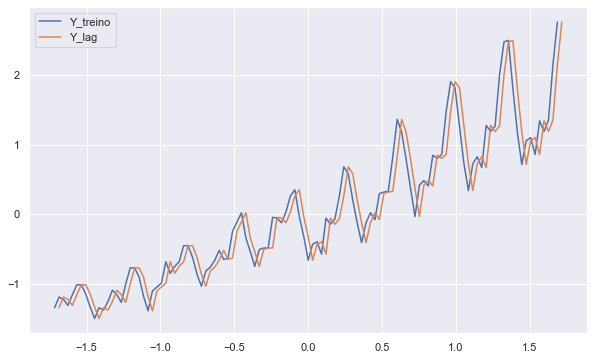

In [11]:
# Gerando x e y
n_inputs = 1
x_treino_lag, y_treino_lag = lag(y_treino_norm, n_inputs)
x_teste_lag, y_teste_lag = lag(y_teste_norm, n_inputs)

# Visualizando a ideia de y_lag:
plt.figure()
sns.lineplot(x=x_treino_norm[:-n_inputs,0], y=y_treino_norm[n_inputs:,0], label='Y_treino')
sns.lineplot(x=x_treino_norm[n_inputs:,0], y=y_treino_lag[:,0], label='Y_lag')
plt.show()

In [12]:
# Definição do modelo para esse caso
modelo_lag = keras.Sequential([
    keras.layers.Dense(8, input_dim=n_inputs, kernel_initializer='random_uniform',
                       activation='linear', use_bias=False),
    keras.layers.Dense(64, kernel_initializer='random_uniform', activation='sigmoid', use_bias=False),
    keras.layers.Dense(1, kernel_initializer='random_uniform', activation='linear', use_bias=False)
])
modelo_lag.summary()
# Compilando e ajustando
modelo_lag.compile(optimizer='Adam', loss='mean_squared_error')
modelo_lag.fit(x_treino_lag, y_treino_lag, epochs=300, verbose=0)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8)                 8         
                                                                 
 dense_5 (Dense)             (None, 64)                512       
                                                                 
 dense_6 (Dense)             (None, 1)                 64        
                                                                 
Total params: 584
Trainable params: 584
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Previsões --> valores reais
y_treino_lag_predict = normalizador_y.inverse_transform(modelo_lag.predict(x_treino_lag))
y_teste_lag_predict = normalizador_y.inverse_transform(modelo_lag.predict(x_teste_lag))

1/1 [==============================] - 0s 21ms/step


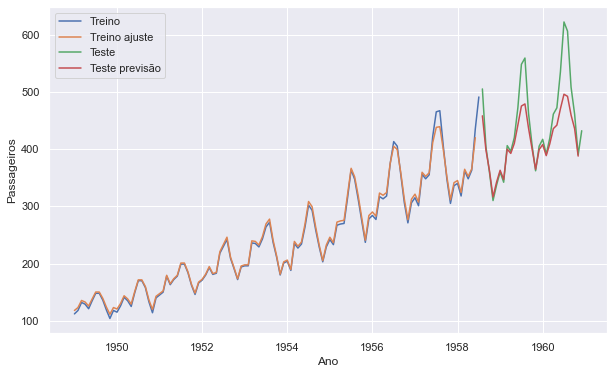

In [14]:
# Plots
plt.figure()
sns.lineplot(x=x_treino, y=y_treino, label='Treino')
sns.lineplot(x=x_treino[:len(y_treino_lag_predict)],
             y=y_treino_lag_predict[:, 0], label='Treino ajuste')
sns.lineplot(x=x_teste, y=y_teste, label='Teste')
sns.lineplot(x=x_teste[:len(y_teste_lag_predict)],
            y=y_teste_lag_predict[:, 0], label='Teste previsão')
plt.xlabel('Ano')
plt.ylabel('Passageiros')
plt.show()

Esse foi o resultado utilizando, para cada previsão, um ponto de entrada; o mesmo que dizer: utilizar as informações de apenas 1 ano conhecido (o mais recente) para prever o próximo). Outra opção, como discutido, é fornecer mais inputs simultâneos ao algoritmo.

In [15]:
# Repetindo o processo para um número de inputs = 4
n_inputs = 4
x_treino_lag, y_treino_lag = lag(y_treino_norm, n_inputs)
x_teste_lag, y_teste_lag = lag(y_teste_norm, n_inputs)

# Definição do modelo
modelo_lag = keras.Sequential([
    keras.layers.Dense(8, input_dim=n_inputs, kernel_initializer='random_uniform',
                       activation='linear'),
    keras.layers.Dense(64, kernel_initializer='random_uniform', activation='sigmoid'),
    keras.layers.Dense(1, kernel_initializer='random_uniform', activation='linear')
])
modelo_lag.summary()
# Compilando e ajustando
modelo_lag.compile(optimizer='Adam', loss='mean_squared_error')
modelo_lag.fit(x_treino_lag, y_treino_lag, epochs=400, verbose=0)

# Previsões --> valores reais
y_treino_lag_predict = normalizador_y.inverse_transform(modelo_lag.predict(x_treino_lag))
y_teste_lag_predict = normalizador_y.inverse_transform(modelo_lag.predict(x_teste_lag))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 8)                 40        
                                                                 
 dense_8 (Dense)             (None, 64)                576       
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 681
Trainable params: 681
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 18ms/step


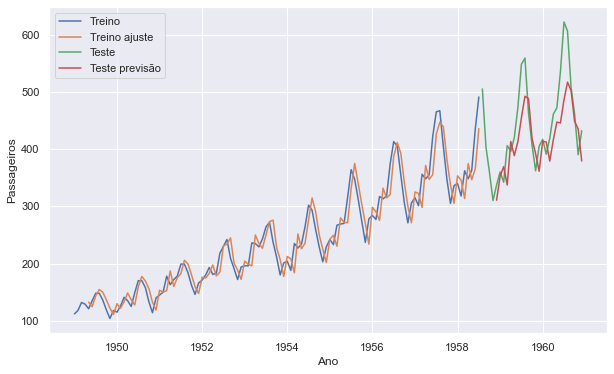

In [16]:
y_treino_lag_transf = normalizador_y.inverse_transform(y_treino_lag)
y_teste_lag_transf = normalizador_y.inverse_transform(y_teste_lag)

# Plots
plt.figure()
sns.lineplot(x=x_treino, y=y_treino, label='Treino')
sns.lineplot(x=x_treino[n_inputs:],
             y=y_treino_lag_predict[:, 0], label='Treino ajuste')
sns.lineplot(x=x_teste, y=y_teste, label='Teste')
sns.lineplot(x=x_teste[n_inputs:],
            y=y_teste_lag_predict[:, 0], label='Teste previsão')
plt.xlabel('Ano')
plt.ylabel('Passageiros')
plt.show()

# 04. Redes recorrentes

In [17]:
# Carregamento da segunda base de dados
uri = 'https://raw.githubusercontent.com/alura-cursos/deeptime/aula4/bicicletas.csv'
dados_bike = vaex.from_pandas(pd.read_csv(uri))

print(dados_bike.shape)
dados_bike.head(5)

(17414, 10)


#,datas,contagem,temperatura,sensacao,umidade,vel_vento,clima,feriado,final_ds,estacao
0,2015-01-04 00:00:00,182,3,2,93,6,3,0,1,3
1,2015-01-04 01:00:00,138,3,2.5,93,5,1,0,1,3
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0,1,0,1,3
3,2015-01-04 03:00:00,72,2,2,100,0,1,0,1,3
4,2015-01-04 04:00:00,47,2,0,93,6.5,1,0,1,3


In [18]:
# Reformatando as datas para o formato YYYYMM
dados_bike['datas'] = dados_bike['datas'].astype('datetime64')
dados_bike['datas'] = dados_bike.datas.dt.strftime('%Y%m').astype('int')

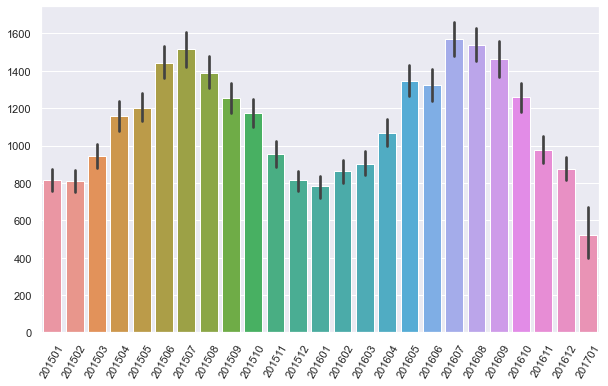

In [19]:
# Visualizando contagem x data
plt.figure()
sns.barplot(x=dados_bike.datas.to_numpy(), y=dados_bike.contagem.to_numpy())
plt.xticks(rotation=60)
plt.show()

Nesse dataset, também será seguida a ideia de usar os dados Y como entrada e saída, aqui tendo Y = 'contagem'.

In [20]:
# Divisão treino/teste
y_treino, y_teste = train_test_split(dados_bike.contagem.to_numpy(), test_size=0.10, shuffle=False)

# Normalizador
norm = StandardScaler().fit(y_treino.reshape(-1, 1))
# Transformando 
y_treino_norm = norm.transform(y_treino.reshape(-1, 1))
y_teste_norm = norm.transform(y_teste.reshape(-1, 1))

# Dividindo em entrada e saída
x_treino_lag, y_treino_lag = lag(y_treino_norm, 10)
x_teste_lag, y_teste_lag = lag(y_teste_norm, 10)

In [21]:
# Será usada uma rede neural do tipo LSTM (long short term memory), que usa uma entrada de 3 dimensões
# Convertendo as entradas:
x_treino_lag = x_treino_lag.reshape(x_treino_lag.shape[0], x_treino_lag.shape[1], 1)
x_teste_lag = x_teste_lag.reshape(x_teste_lag.shape[0], x_teste_lag.shape[1], 1)

# Instanciando o modelo
rede_lstm = keras.Sequential([
    keras.layers.LSTM(16, input_shape=(x_treino_lag.shape[1], x_treino_lag.shape[2])),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1)
])
# Compilando
rede_lstm.compile(loss='mean_squared_error', optimizer='RMSProp')

rede_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1152      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


# 05. Avaliando o resultado

In [22]:
# Ajustando
epoch_num = 30
historico = rede_lstm.fit(x_treino_lag, y_treino_lag, epochs=epoch_num, validation_split=0.20, verbose=0)

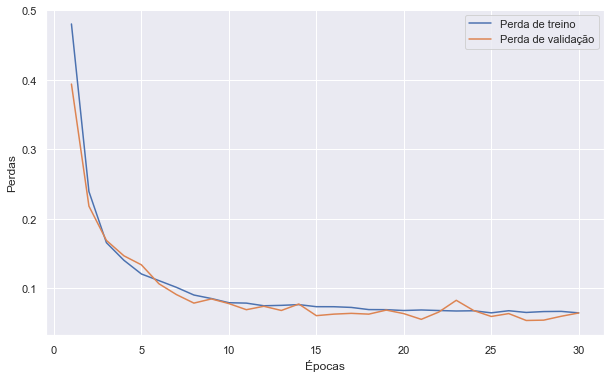

In [23]:
# Visualizando perdas de treino e validação:
epochs = list(range(1, epoch_num+1))
plt.figure()
sns.lineplot(x=epochs, y=historico.history['loss'], label='Perda de treino')
sns.lineplot(x=epochs, y=historico.history['val_loss'], label='Perda de validação')
plt.xlabel('Épocas')
plt.ylabel('Perdas')
plt.show()

Testando, também, a rede neural do tipo GRU para esse caso de regressão:

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 16)                912       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________


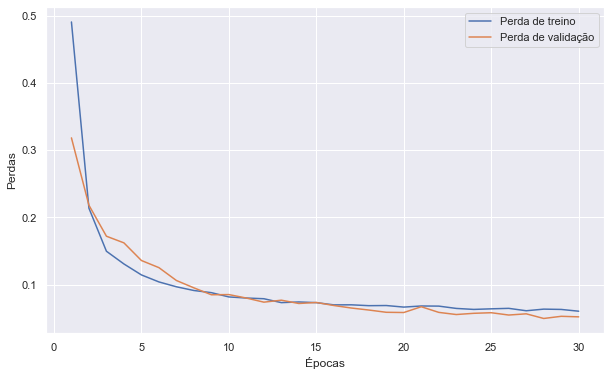

In [24]:
# Instanciando o modelo
rede_gru = keras.Sequential([
    keras.layers.GRU(16, input_shape=(x_treino_lag.shape[1], x_treino_lag.shape[2])),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1)
])
# Compilando
rede_gru.compile(loss='mean_squared_error', optimizer='RMSProp')

rede_gru.summary()

# Ajustando
epoch_num = 30
historico = rede_gru.fit(x_treino_lag, y_treino_lag, epochs=epoch_num, validation_split=0.20, verbose=0)

# Visualizando perdas de treino e validação:
epochs = list(range(1, epoch_num+1))
plt.figure()
sns.lineplot(x=epochs, y=historico.history['loss'], label='Perda de treino')
sns.lineplot(x=epochs, y=historico.history['val_loss'], label='Perda de validação')
plt.xlabel('Épocas')
plt.ylabel('Perdas')
plt.show()